In [1]:
# Libraries

# Operating System Interaction
import os # to interact with the operating system
import glob # to find files in directories

# Numerical and Data Handling
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import xarray as xr # for n-dimensional data manipulation

# Data Interpolation and Signal Processing
from scipy.interpolate import griddata # for data interpolation
from scipy import signal # for signal processing
import scipy.fftpack as fp # for fast fourier transforms

# Convolution Operations
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans # for convolution operations

# Plotting and Visualization 
import matplotlib.pyplot as plt # for plotting
import cartopy.crs as ccrs # for cartographic projections
import cartopy.feature as cfeature # for cartographic features
import cartopy # for cartographic projections
import xesmf as xe # for regridding

# Scientific Computing and Evaluation
import xskillscore # for model evaluation

# System and Performance Management
import sys # for system management
import gc # for garbage collection

# Parallel Computing (Commented Out)
#from dask import delayed, compute

# High Pass Filter

It allows high frequencies to pass while **removing low frequencies**.

$$\eta_{truth} \rightarrow  \eta_{truth} - \eta_{truth}^{BM}$$

## Loading Data

In [2]:
sshdedac = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60_dedac/ssh_dedac_masked_*.nc", combine="nested", concat_dim="time_counter", parallel=True)

In [3]:
sshdedac = sshdedac.drop_vars(['latitude','longitude'])

# Rename nav_lat and nav_lon to lat and lon
sshdedac = sshdedac.rename({'nav_lat': 'lat', 'nav_lon': 'lon'})

# Since lat and lon are 2D coordinates, make sure to assign them properly to your dataset
sshdedac = sshdedac.assign_coords(lat=(('y', 'x'), sshdedac.lat.values),
                                  lon=(('y', 'x'), sshdedac.lon.values))

In [4]:
sshdedac

<xarray.Dataset> Size: 47GB
Dimensions:       (y: 853, x: 788, time_counter: 8760)
Coordinates:
    lat           (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    lon           (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
  * time_counter  (time_counter) datetime64[ns] 70kB 2014-01-01T00:30:00 ... ...
Dimensions without coordinates: y, x
Data variables:
    ssh_dedac     (time_counter, y, x) float64 47GB dask.array<chunksize=(744, 853, 788), meta=np.ndarray>

## Crop

In [4]:
# Define boundaries
lat_min, lat_max = -20, -18
lon_min, lon_max = 164, 166

# Compute the boolean mask arrays for latitude and longitude within the desired range
# Note: This step requires loading the data, which could be memory intensive for very large datasets
# Consider loading only the necessary portions if memory is a constraint
lat_mask = (sshdedac.lat >= lat_min) & (sshdedac.lat <= lat_max)
lon_mask = (sshdedac.lon >= lon_min) & (sshdedac.lon <= lon_max)

# Since these operations are lazy with Dask, compute the masks to get their actual values
lat_mask_computed = lat_mask.compute()
lon_mask_computed = lon_mask.compute()

# Find indices where the mask is True
lat_indices = np.where(lat_mask_computed)
lon_indices = np.where(lon_mask_computed)

# Since lat_indices and lon_indices are tuples of arrays, we need to extract the unique y and x indices
y_indices = np.unique(lat_indices[0])  # y dimension indices
x_indices = np.unique(lon_indices[1])  # x dimension indices

# Selecting the data based on computed indices
# Note: This might still load a large portion of the data into memory, so ensure this step is feasible
sshdedac_cropped = sshdedac.isel(y=y_indices, x=x_indices)

In [7]:
sshdedac_cropped

<xarray.Dataset> Size: 1GB
Dimensions:       (y: 127, x: 121, time_counter: 8760)
Coordinates:
    lat           (y, x) float32 61kB -20.0 -20.0 -20.0 ... -18.01 -18.01 -18.01
    lon           (y, x) float32 61kB 164.0 164.0 164.0 ... 166.0 166.0 166.0
  * time_counter  (time_counter) datetime64[ns] 70kB 2014-01-01T00:30:00 ... ...
Dimensions without coordinates: y, x
Data variables:
    ssh_dedac     (time_counter, y, x) float64 1GB dask.array<chunksize=(744, 127, 121), meta=np.ndarray>

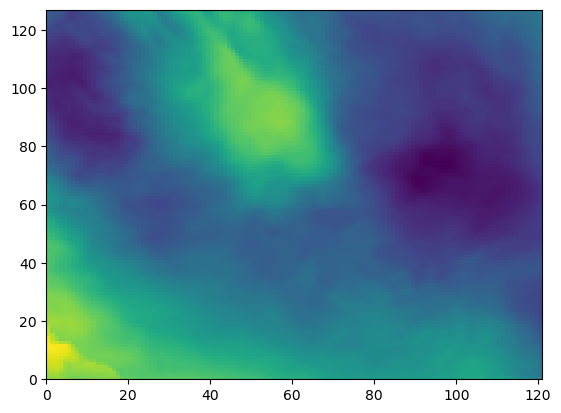

In [6]:
plt.pcolormesh(sshdedac_cropped.ssh_dedac[0])

## Defining variables

In [5]:
# Setting some variables for ease of use later on
longitude = sshdedac_cropped.lon.values
latitude = sshdedac_cropped.lat.values
time = sshdedac_cropped.time_counter.values
nt = time.size
ny = latitude.size
nx = longitude.size

f = 2*(2*np.pi/86164)*np.sin(np.mean(np.deg2rad(latitude))) # Coriolis parameter (-4.75e-05)
T = np.abs(2*np.pi/f) # Including absolute becase the periode has to be positive. (132281.2) 

dt = 3600 # number of seconds in a hour 
window_len = int(2*T//dt) # length of the gaussian filter window (73 hours ~ 3 days)
time_window = np.arange(-window_len,window_len+1) # array time steps to compute the kernel (ok)
exp_window = np.exp(-np.square(time_window/(T/dt))) # array of kernel values (ok)
ntw = time_window.size #(147)
weight = xr.DataArray(exp_window, dims=['window']) #(ok)

In [6]:
# Making a dataarray
sshdedac_cropped_da = sshdedac_cropped['ssh_dedac']

# Cropping days with out NaNs (becasue last 6 hours were not interpolated)
sshdedac_cropped_da = sshdedac_cropped_da.isel(time_counter=slice(0, 8754))

## Gaussian Kernel

In [7]:
rolling_sshdedac_cropped_da = sshdedac_cropped_da.rolling(time_counter=ntw, center=True).construct('window') # Constructing the rolling window

(array([ 46869., 112148.,  84808.,  68334.,  64787.,  70856.,  74865.,
        109194.,  80412.,  25343.]),
 array([0.17380354, 0.30600934, 0.43821514, 0.57042093, 0.70262673,
        0.83483253, 0.96703833, 1.09924412, 1.23144992, 1.36365572,
        1.49586151]),
 <BarContainer object of 10 artists>)

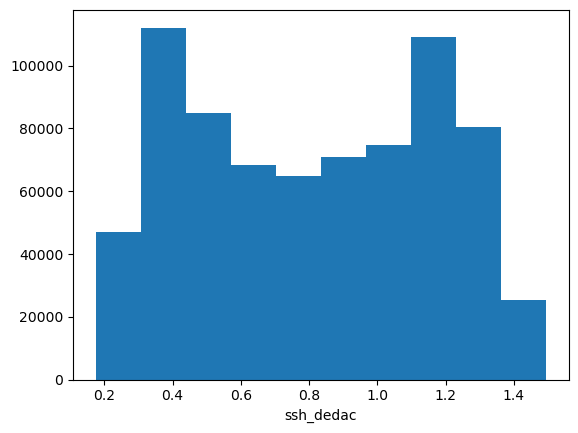

In [8]:
sshdedac_cropped_da.sel(time_counter=slice("2014-01-01", "2014-01-02")).plot()

In [16]:
ssh_bm = rolling_sshdedac_cropped_da.dot(weight, dims=['window'])# / weight.sum()

In [17]:
rolling_sshdedac_cropped_da

<xarray.DataArray 'ssh_dedac' (time_counter: 8754, y: 127, x: 121, window: 147)> Size: 158GB
dask.array<sliding_window_view, shape=(8754, 127, 121, 147), dtype=float64, chunksize=(817, 127, 121, 147), chunktype=numpy.ndarray>
Coordinates:
    lat           (y, x) float32 61kB -20.0 -20.0 -20.0 ... -18.01 -18.01 -18.01
    lon           (y, x) float32 61kB 164.0 164.0 164.0 ... 166.0 166.0 166.0
  * time_counter  (time_counter) datetime64[ns] 70kB 2014-01-01T00:30:00 ... ...
Dimensions without coordinates: y, x, window

In [18]:
ssh_bm

<xarray.DataArray (time_counter: 8754, y: 127, x: 121)> Size: 1GB
dask.array<sum-aggregate, shape=(8754, 127, 121), dtype=float64, chunksize=(817, 127, 121), chunktype=numpy.ndarray>
Coordinates:
    lat           (y, x) float32 61kB -20.0 -20.0 -20.0 ... -18.01 -18.01 -18.01
    lon           (y, x) float32 61kB 164.0 164.0 164.0 ... 166.0 166.0 166.0
  * time_counter  (time_counter) datetime64[ns] 70kB 2014-01-01T00:30:00 ... ...
Dimensions without coordinates: y, x

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

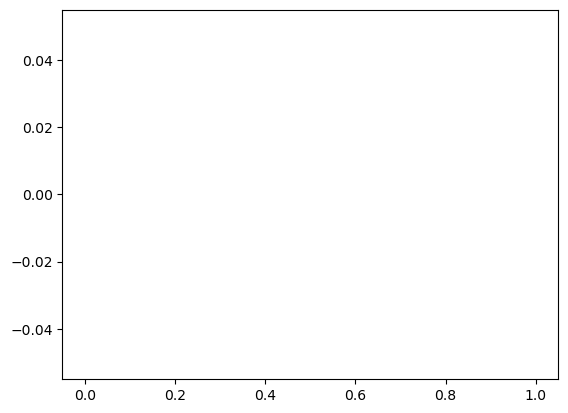

In [11]:
ssh_bm.sel(time_counter=slice("2014-01-01", "2014-01-02")).plot()

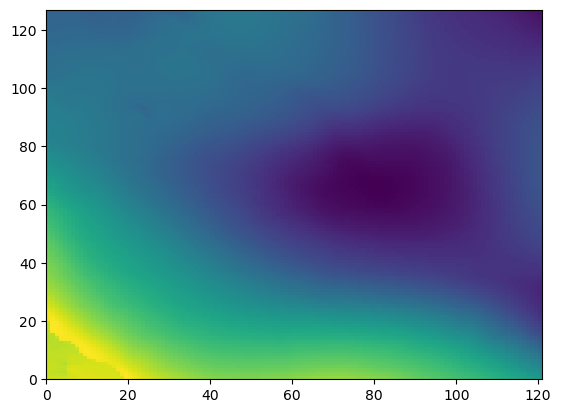

In [21]:
plt.pcolormesh(ssh_bm[100])